<a href="https://colab.research.google.com/github/pdrzxzz/breast_cancer_wisconsin_diagnostic/blob/main/breast_cancer_wisconsin_diagnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""Machine Learning Project - Breast Cancer Classification

A comparative analysis of different classification algorithms on the dataset. The classifiers to be evaluated are:
* Decision Trees
* Naive Bayes
* Logistic Regression
* K-Nearest Neighbors (k-NN)
"""

# --- General Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Preprocessing and Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.naive_bayes import GaussianNB  # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier  # KNN

# Metrics and Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score, make_scorer

# Utilities
from ucimlrepo import fetch_ucirepo
from scipy.stats import loguniform
from sklearn.model_selection import StratifiedShuffleSplit
from math import ceil

In [ ]:
# Set visualization style
sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
#### FUNCTIONS ####

# --- Enhanced Visualization Functions ---
def personalized_confusion_matrix(model_name, y_true, y_pred, ax, cmap):
    """
    Create a styled confusion matrix with detailed annotations.

    Args:
        model_name (str): Name of the model
        y_true: True labels
        y_pred: Predicted labels
        ax: Matplotlib axis to plot on
    """
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()

    # Matrix labels
    labels = np.array([['TN', 'FP'], ['FN', 'TP']])
    percentages = cm / total * 100
    annot = np.empty_like(cm).astype(str)

    # Create annotation with label, absolute count, and percentage
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{labels[i, j]}\n{cm[i, j]}\n{percentages[i, j]:.1f}%'

    # Create DataFrame for the heatmap
    df_cm = pd.DataFrame(cm, index=['Actual: B', 'Actual: M'], columns=['Predicted: B', 'Predicted: M'])

    # Plot with seaborn
    sns.heatmap(df_cm, annot=annot, fmt="", vmin=-300, vmax=130, cmap=cmap, cbar=False, ax=ax)
    ax.set_title(f'{model_name} - Confusion Matrix', weight='bold', fontsize=10)

def personalized_classification_report(model_name, y_true, y_pred, ax, cmap):
    """
    Create a styled classification report heatmap.

    Args:
        model_name (str): Name of the model
        y_true: True labels
        y_pred: Predicted labels
        ax: Matplotlib axis to plot on
    """
    clf_report = classification_report(y_true, y_pred, output_dict=True)
    clf_report.pop("accuracy", None)
    df_report = pd.DataFrame(clf_report).iloc[:-1, :].T

    # Plot heatmap of classification metrics
    sns.heatmap(df_report, vmin=0.7, vmax=1, cmap=cmap, annot=True, cbar=False, ax=ax)
    ax.set_title(f'{model_name} - Classification Report', weight='bold', fontsize=10)

    # Add accuracy score below the heatmap
    accuracy = accuracy_score(y_true, y_pred)
    ax.text(0.5, -0.3, f'Accuracy: {accuracy:.2f}',
            ha='center', va='center', fontsize=18, transform=ax.transAxes)

def evaluate_classifier(model, model_name, X_train, X_test, y_train, y_test,
                        classification_ax=None, confusion_matrix_ax=None, cmap='Greens'):
    """
    Evaluate a classifier and plot results on provided axes.

    Args:
        model: Classifier instance
        model_name (str): Name of the model
        X_train: Training features
        X_test: Testing features
        y_train: Training target
        y_test: Testing target
        classification_ax: Axis for classification report
        confusion_matrix_ax: Axis for confusion matrix
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if classification_ax:
        personalized_classification_report(model_name, y_test, y_pred, ax=classification_ax, cmap=cmap)

    if confusion_matrix_ax:
        personalized_confusion_matrix(model_name, y_test, y_pred, ax=confusion_matrix_ax, cmap=cmap)

def compare_classifiers(models, models_names, X_train, X_test, y_train, y_test, cmaps):
    """
    Compare multiple classifiers in a single visualization.

    Args:
        models: List of classifier instances
        models_names: List of classifier names
        X_train: Training features
        X_test: Testing features
        y_train: Training target
        y_test: Testing target
    """
    assert len(models) == len(models_names)
    assert len(models) <= 4

    fig, axs = plt.subplots(2, len(models), figsize=(len(models)*5, 10))
    fig.suptitle("Classifiers Comparison", size="xx-large", weight="bold")

    # Plot classification reports on first row
    for i, (model, name, cmap) in enumerate(zip(models, models_names, cmaps)):
        evaluate_classifier(
            model, name,
            X_train, X_test, y_train, y_test,
            classification_ax=axs[0, i] if len(models) > 1 else axs[0],
            cmap=cmap
        )

    # Plot confusion matrices on second row
    for i, (model, name, cmap) in enumerate(zip(models, models_names, cmaps)):
        evaluate_classifier(
            model, name,
            X_train, X_test, y_train, y_test,
            confusion_matrix_ax=axs[1, i] if len(models) > 1 else axs[1],
            cmap=cmap
        )

    # Add explanatory footer
    fig.text(
        x=0.5, y=0.01,
        s="TN: True Negative | FP: False Positive | FN: False Negative | TP: True Positive",
        ha='center', fontsize="medium"
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08)
    plt.show()

# --- Data Preparation ---
def load_and_prepare_data():
    """
    Load the breast cancer dataset and prepare features (X) and target (y).

    Returns:
        X (pd.DataFrame): Features dataframe.
        y (np.array): Target array.
    """
    # Fetch dataset
    breast_cancer_data = fetch_ucirepo(id=17)

    # Data as pandas dataframes
    X = breast_cancer_data.data.features
    y = breast_cancer_data.data.targets.values.ravel()

    return X, y

def split_data(X, y, test_size=0.3, random_state=42):
    """
    Split data into training and testing sets with stratification.

    Args:
        X (pd.DataFrame): Features dataframe.
        y (np.array): Target array.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Controls the shuffling applied to the data before splitting.

    Returns:
        X_train, X_test, y_train, y_test: Split datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y  # Stratification to maintain class distribution
    )

    print("Data split into training (70%) and testing (30%).")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test

def plot_correlation_matrix(X_train, y_train, title_suffix=''):
    """
    Plot a correlation matrix between features and target.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (np.array): Training target.
    """
    df = X_train.copy()
    df['target'] = y_train
    df['target'] = df['target'].map({'M': 1, 'B': 0})  # Convert target to numeric

    correlation_matrix = df.corr()
    correlation_with_target = correlation_matrix['target'].sort_values(ascending=False)

    plt.figure(figsize=(20, 8))
    barplot = sns.barplot(
      x=correlation_with_target.values,
      y=correlation_with_target.index,
      hue=correlation_with_target.index,
      palette='Spectral',
      legend=False,
      orient='h'
    )

    plt.title(f'Feature Correlation with Target {title_suffix}', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)

    for container in barplot.containers:
        barplot.bar_label(container, fmt='%.2f', fontsize=10, padding=3)

    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_boxplots(X_train, title_suffix=''):
    """
    Plot boxplots for each feature to visualize distributions and outliers.

    Args:
        X_train (pd.DataFrame): Training features.
        title_suffix (str): Additional text for the plot title.
    """
    X_train_melted = pd.melt(X_train)

    plt.figure(figsize=(20, 10))
    sns.boxplot(
        data=X_train_melted,
        x='variable',
        y='value',
        color='plum'
    )

    plt.title(f'Feature Boxplots {title_suffix}', fontsize=18)
    plt.ylabel('Values', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_histograms(X_train, n_cols=3, title_suffix=''):
    """
    Plot histograms for each feature to visualize distributions.

    Args:
        X_train (pd.DataFrame): Training features.
        n_cols (int): Number of columns in the subplot grid.
        title_suffix (str): Optional suffix to add to the title.
    """
    n_features = len(X_train.columns)
    n_rows = ceil(n_features / n_cols)

    # Create subplot grid (handle 1x1 grid as special case)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

    # Flatten axes array for uniform handling
    if n_features > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Ensure single plot is in a list

    # Plot histograms for each feature
    for i, column in enumerate(X_train.columns):
        sns.histplot(X_train[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}', fontsize=10)
        axes[i].set_xlabel('')

    # Hide unused axes
    for j in range(n_features, len(axes)):
        axes[j].set_visible(False)

    # Adjust layout and display
    fig.suptitle(f'Feature Distributions {title_suffix}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Prevent suptitle overlap
    plt.show()

# --- Preprocessing ---
def remove_outliers(X_train, y_train, threshold=3):
    """
    Remove outliers using the IQR method.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (np.array): Training target.
        threshold (float): Multiplier for IQR to determine outlier bounds.

    Returns:
        X_train_clean, y_train_clean: Data with outliers removed.
    """
    print(f"Original number of training samples: {X_train.shape[0]}")

    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    print("\n--- Outlier Count per Column ---")
    outliers_per_column = ((X_train < lower_bound) | (X_train > upper_bound)).sum()
    print(outliers_per_column[outliers_per_column > 0].sort_values(ascending=False))

    outlier_indices = ((X_train < lower_bound) | (X_train > upper_bound)).any(axis=1)
    print(f"\nNumber of rows with at least one outlier: {outlier_indices.sum()}")

    X_train_clean = X_train[~outlier_indices]
    y_train_clean = y_train[~outlier_indices]

    print(f"Number of training samples after outlier removal: {X_train_clean.shape[0]}")

    return X_train_clean, y_train_clean

def create_preprocessor():
    """
    Create a preprocessing pipeline with standardization and power transformation.

    Returns:
        Pipeline: Preprocessing pipeline.
    """
    preprocessor = Pipeline(steps=[
        ('standard_scaler', StandardScaler()),
        ('power_transformer', PowerTransformer())
    ])
    return preprocessor

# --- Model Training and Evaluation ---
def plot_roc_curve(models, X_test, y_test):
    """
    Plot ROC curves for multiple models.

    Args:
        models (dict): Dictionary of model names and their instances.
        X_test: Testing features.
        y_test: Testing target.
    """
    y_test_numeric = y_test.copy()
    y_test_numeric[y_test_numeric == 'M'] = 1
    y_test_numeric[y_test_numeric == 'B'] = 0
    y_test_numeric = y_test_numeric.astype(int)

    plt.figure(figsize=(20, 9))
    palette = ['darkorange', 'green', 'red', 'purple']

    for i, (name, model) in enumerate(models.items()):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_numeric, y_prob)
        roc_auc = auc(fpr, tpr)

        sns.lineplot(
            x=fpr,
            y=tpr,
            label=f'{name} (AUC = {roc_auc:.3f})',
            color=palette[i],
            linewidth=2.5,
            errorbar=None
        )

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curves for Optimized Models', fontsize=18)
    plt.legend(loc="lower right", fontsize=11)
    sns.despine()
    plt.grid(True)
    plt.show()



def plot_learning_curves(estimator, title, X, y,
                         test_size=0.2,
                         n_splits=5,
                         train_frac_steps=20,
                         random_state=42):
    """
    Generate learning curves for precision, recall, and F1 (macro average),
    keeping the test set fixed and using multiple stratified splits
    for each training size.

    Args:
        estimator: model instance with fit() and predict().
        title (str): title for the plot.
        X (DataFrame or ndarray): feature matrix.
        y (Series or ndarray): target vector.
        test_size (float): fraction reserved for the final test set (0.0–1.0).
        n_splits (int): number of repetitions per training size.
        train_frac_steps (int): number of points between 5% and 100% of the training pool.
        random_state (int): seed for reproducibility.
    """
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    # Split once to create a fixed test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # Define fractions and absolute training sizes
    train_fracs = np.linspace(0.05, 1.0, train_frac_steps)
    train_sizes = (train_fracs * len(X_train_full)).astype(int)

    # Prepare results storage
    results = {
        'train_size': train_sizes,
        'precision_mean': [],
        'precision_std': [],
        'recall_mean': [],
        'recall_std': [],
        'f1_mean': [],
        'f1_std': []
    }

    print(f"[INFO] Generating learning curves: {title}")

    # Loop over each training size
    for size in train_sizes:
        if size <= 0:
            continue

        # Edge case: full training set
        if size >= len(X_train_full):
            estimator.fit(X_train_full, y_train_full)
            y_pred = estimator.predict(X_test)
            rpt = classification_report(
                y_test,
                y_pred,
                output_dict=True,
                zero_division=0
            )
            pm = rpt['macro avg']['precision']
            rm = rpt['macro avg']['recall']
            fm = rpt['macro avg']['f1-score']
            results['precision_mean'].append(pm)
            results['precision_std'].append(0.0)
            results['recall_mean'].append(rm)
            results['recall_std'].append(0.0)
            results['f1_mean'].append(fm)
            results['f1_std'].append(0.0)
            continue

        precisions = []
        recalls = []
        f1s = []

        # StratifiedShuffleSplit for multiple repetitions
        sss = StratifiedShuffleSplit(
            n_splits=n_splits,
            train_size=size,
            random_state=random_state
        )

        for train_idx, _ in sss.split(X_train_full, y_train_full):
            X_sub = X_train_full[train_idx]
            y_sub = y_train_full[train_idx]

            # Fit on the subset and evaluate on the fixed test set
            estimator.fit(X_sub, y_sub)
            y_pred = estimator.predict(X_test)

            rpt = classification_report(
                y_test,
                y_pred,
                output_dict=True,
                zero_division=0
            )

            precisions.append(rpt['macro avg']['precision'])
            recalls.append(rpt['macro avg']['recall'])
            f1s.append(rpt['macro avg']['f1-score'])

        # Store mean and standard deviation
        results['precision_mean'].append(np.mean(precisions))
        results['precision_std'].append(np.std(precisions))
        results['recall_mean'].append(np.mean(recalls))
        results['recall_std'].append(np.std(recalls))
        results['f1_mean'].append(np.mean(f1s))
        results['f1_std'].append(np.std(f1s))

    # Plot with error bars
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Learning Curves: {title}', fontsize=16)

    # Precision plot
    plt.subplot(1, 3, 1)
    plt.errorbar(
        results['train_size'],
        results['precision_mean'],
        yerr=results['precision_std'],
        marker='o', linestyle='-'
    )
    plt.xlabel('Training Set Size')
    plt.ylabel('Precision (macro avg)')
    plt.title('Precision vs. Training Size')
    plt.grid(True)

    # Recall plot
    plt.subplot(1, 3, 2)
    plt.errorbar(
        results['train_size'],
        results['recall_mean'],
        yerr=results['recall_std'],
        marker='o', linestyle='-'
    )
    plt.xlabel('Training Set Size')
    plt.ylabel('Recall (macro avg)')
    plt.title('Recall vs. Training Size')
    plt.grid(True)

    # F1-score plot
    plt.subplot(1, 3, 3)
    plt.errorbar(
        results['train_size'],
        results['f1_mean'],
        yerr=results['f1_std'],
        marker='o', linestyle='-'
    )
    plt.xlabel('Training Set Size')
    plt.ylabel('F1-Score (macro avg)')
    plt.title('F1-Score vs. Training Size')
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Hyperparameter Optimization ---
def optimize_decision_tree(X_train, y_train):
    """Optimize Decision Tree hyperparameters"""
    recall_scorer = make_scorer(recall_score, pos_label='M')

    param_grid_tree = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 7, 9, 11, 13],
        'min_samples_leaf': [3, 5, 7],
        'min_samples_split': [5, 10, 15],
        'max_features': ['sqrt', 'log2'],
        'class_weight': [None, 'balanced']
    }

    grid_search = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid_tree,
        cv=10,
        scoring=recall_scorer,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best Decision Tree params: {grid_search.best_params_}")
    return grid_search.best_estimator_

def optimize_logistic_regression(X_train, y_train):
    """Optimize Logistic Regression hyperparameters"""
    recall_scorer = make_scorer(recall_score, pos_label='M')

    param_distributions_lr = [
        {
            'C': loguniform(0.1, 100),
            'penalty': ['l1'],
            'solver': ['liblinear', 'saga']
        },
        {
            'C': loguniform(0.1, 100),
            'penalty': ['l2'],
            'solver': ['liblinear', 'saga']
        }
    ]

    random_search = RandomizedSearchCV(
        LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'),
        param_distributions=param_distributions_lr,
        cv=10,
        scoring=recall_scorer,
        n_iter=50,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    print(f"Best Logistic Regression params: {random_search.best_params_}")
    return random_search.best_estimator_

def optimize_knn(X_train, y_train):
    """Optimize KNN hyperparameters"""
    recall_scorer = make_scorer(recall_score, pos_label='M')

    param_grid = {
        'n_neighbors': [3, 4, 5, 6, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean']
    }

    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid=param_grid,
        cv=10,
        scoring=recall_scorer,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best KNN params: {grid_search.best_params_}")
    return grid_search.best_estimator_

def optimize_naive_bayes(X_train, y_train):
    """Optimize Naive Bayes hyperparameters"""
    recall_scorer = make_scorer(recall_score, pos_label='M')

    param_grid = {
        'var_smoothing': np.logspace(0, -9, num=100)
    }

    grid_search = GridSearchCV(
        GaussianNB(),
        param_grid=param_grid,
        cv=10,
        scoring=recall_scorer,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best Naive Bayes params: {grid_search.best_params_}")
    return grid_search.best_estimator_


In [ ]:
# Load and prepare data
X, y = load_and_prepare_data()
X_train, X_test, y_train, y_test = split_data(X, y)

Data split into training (70%) and testing (30%).
Training set size: 398 samples
Testing set size: 171 samples


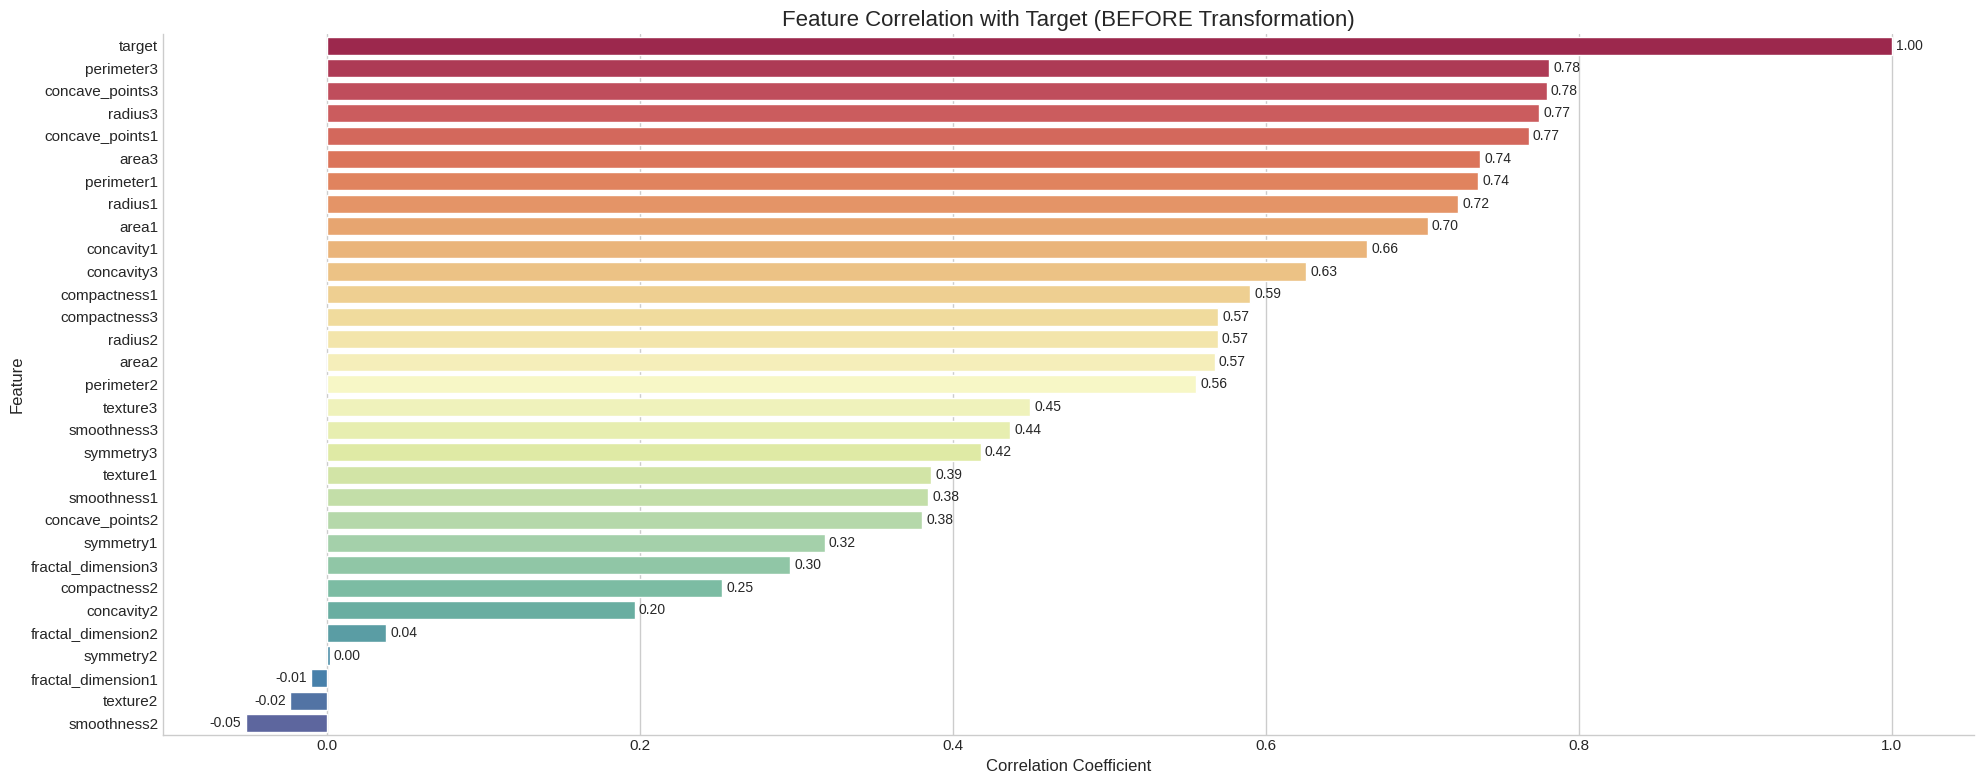

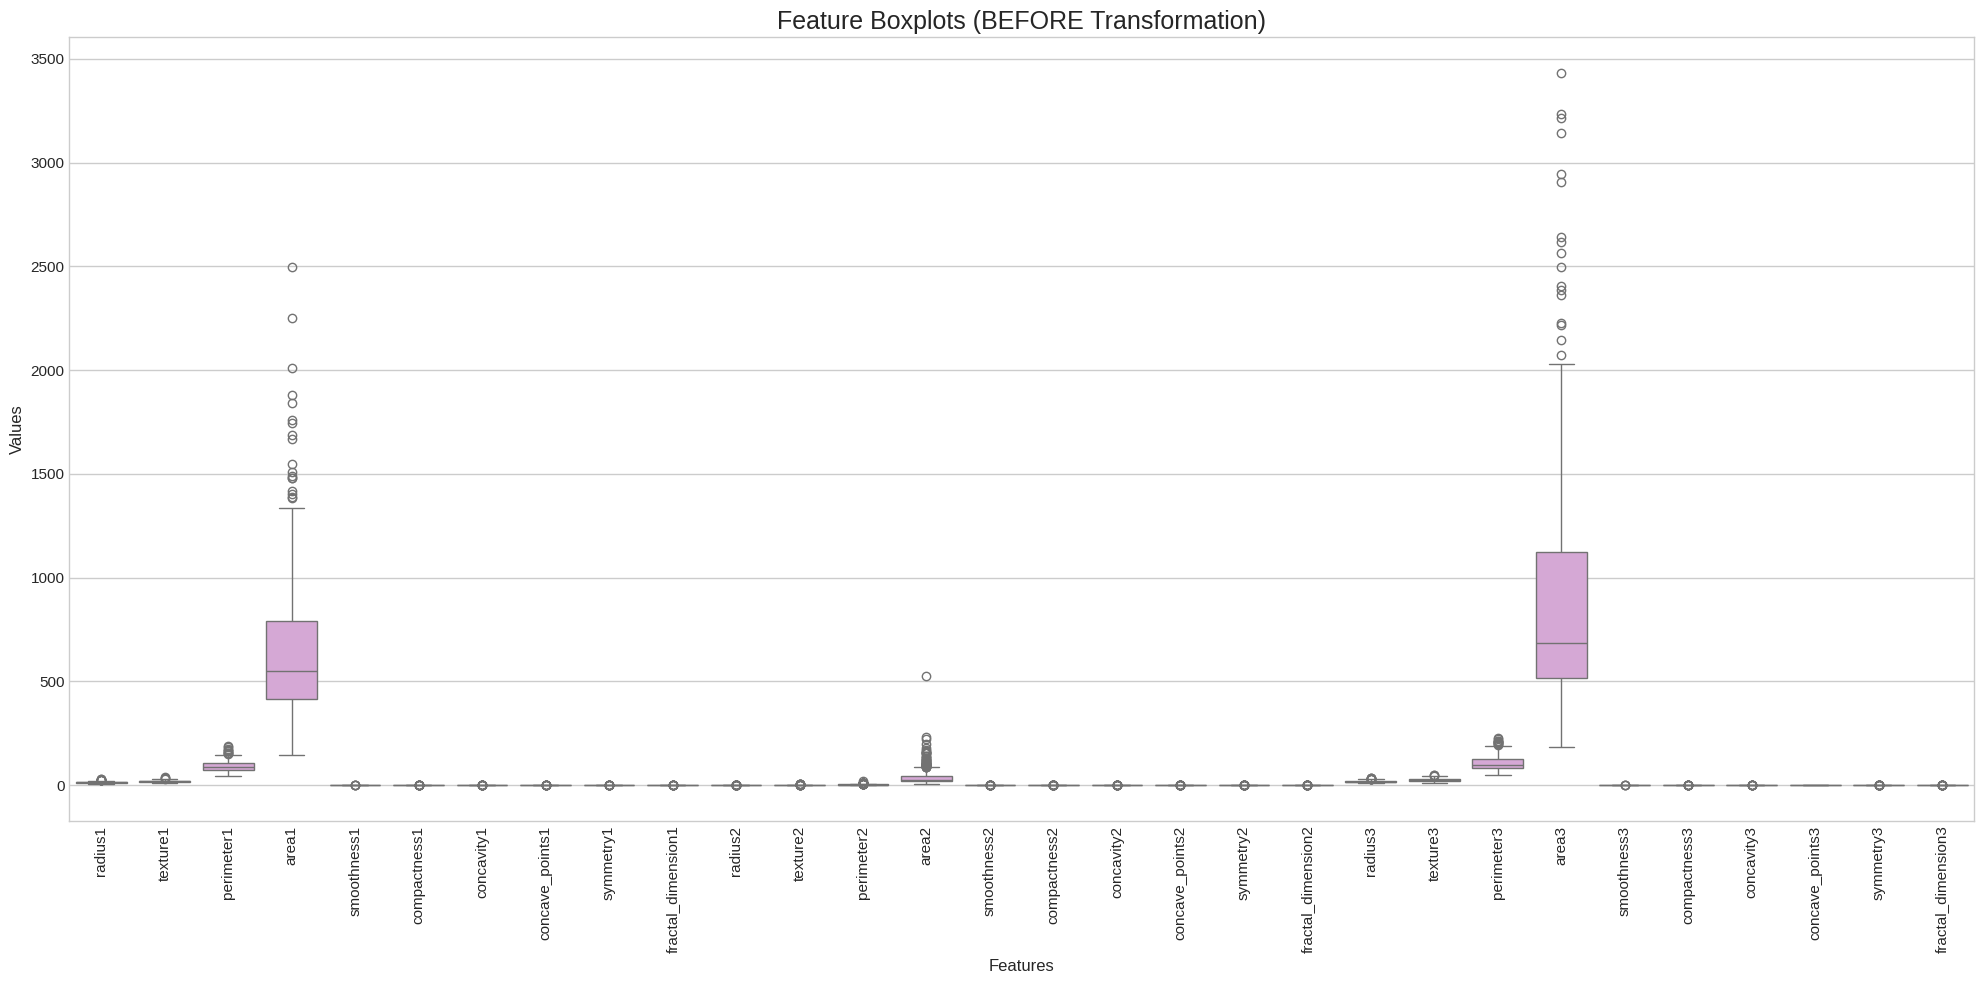

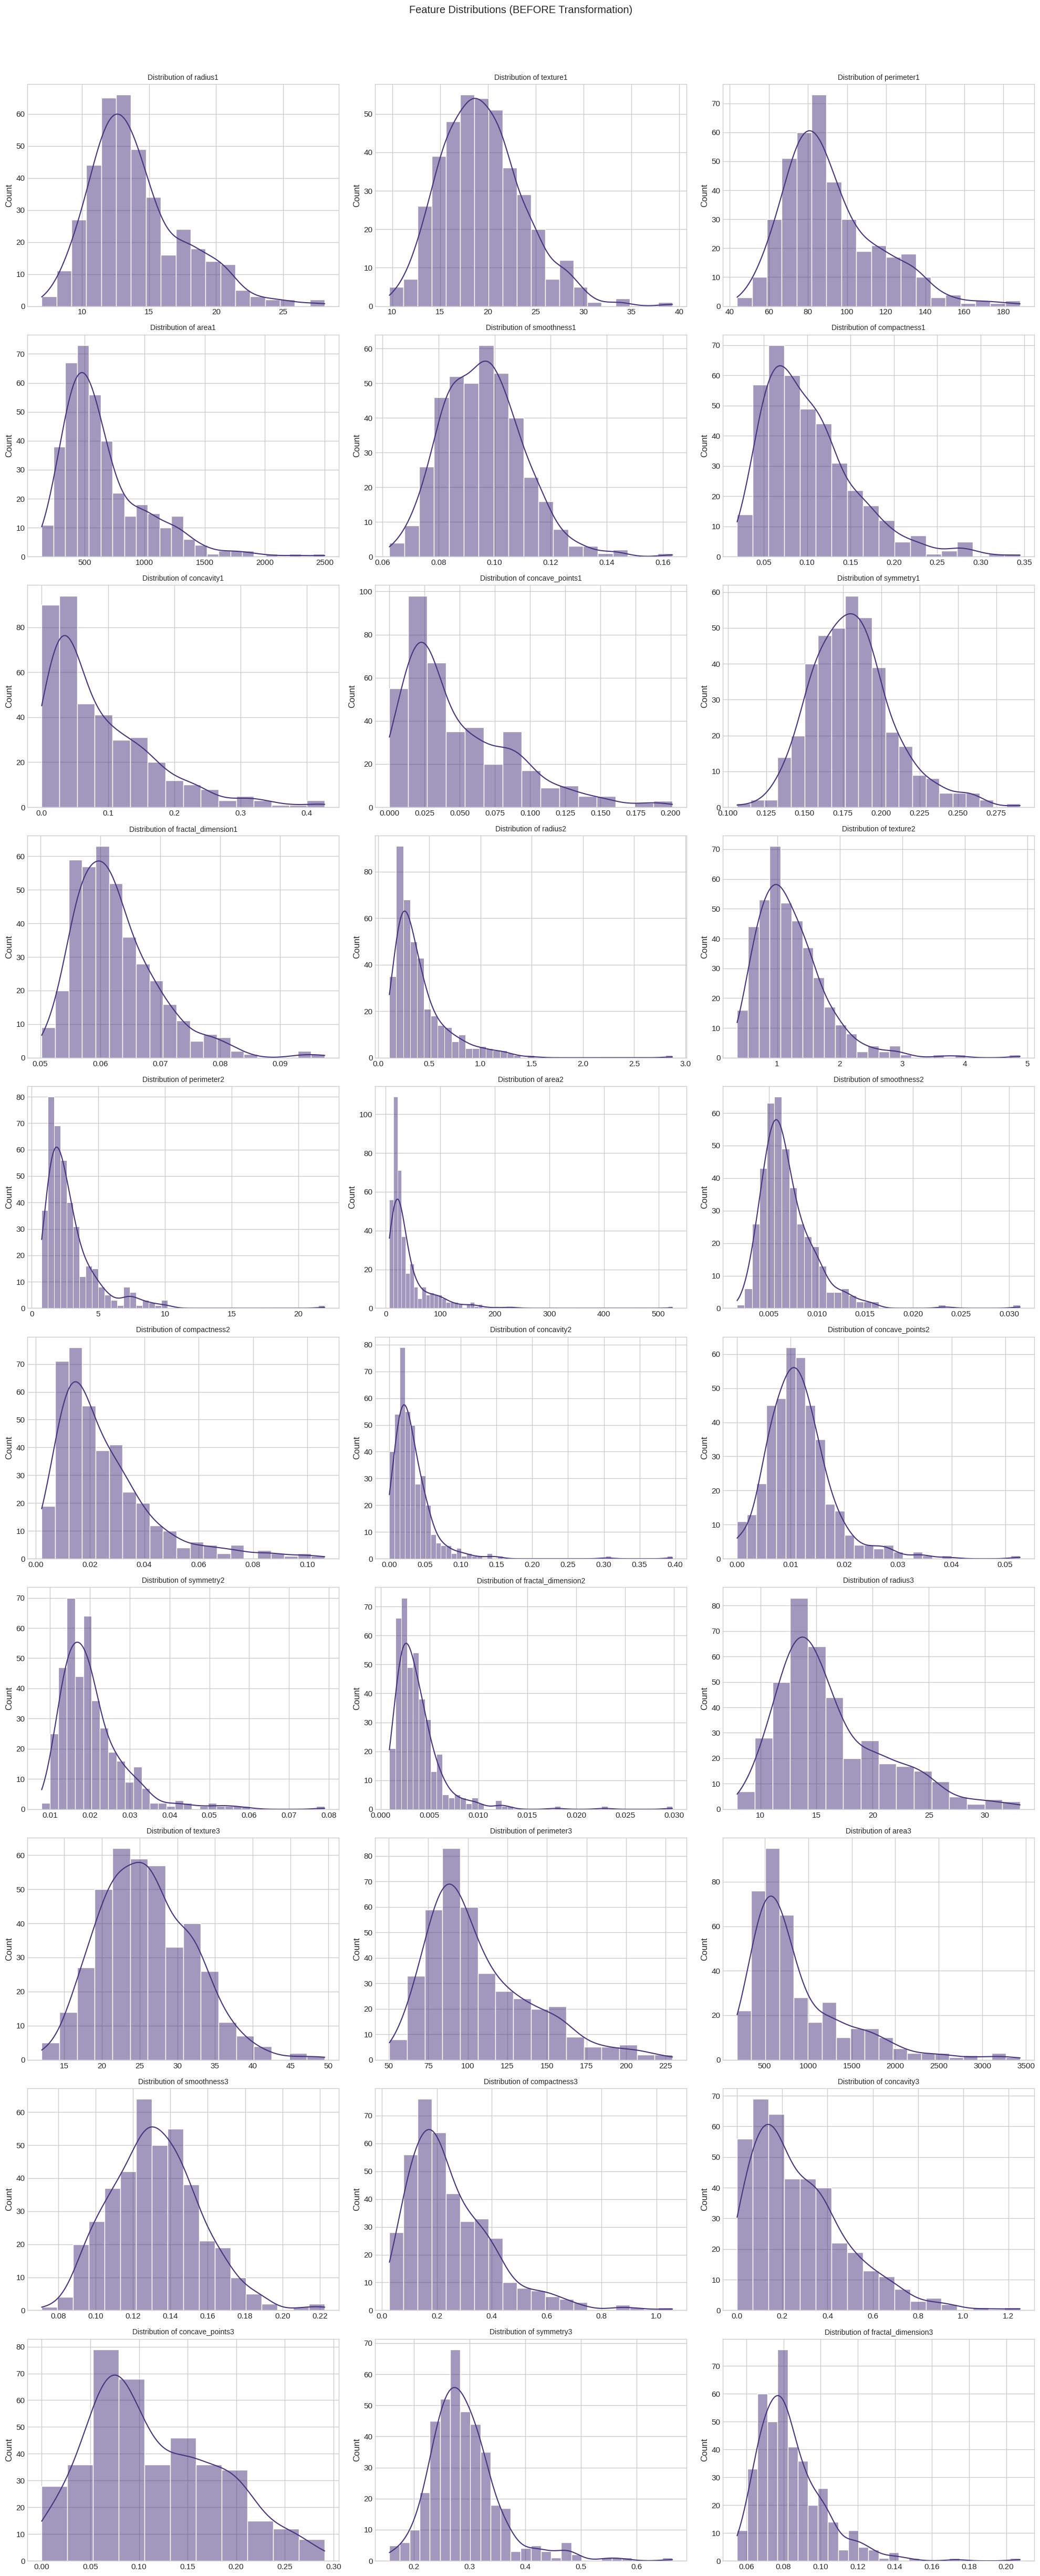

In [ ]:
# Visualize untransformed data
plot_correlation_matrix(X_train, y_train, title_suffix='(BEFORE Transformation)')
plot_boxplots(X_train, title_suffix='(BEFORE Transformation)')
plot_histograms(X_train, title_suffix='(BEFORE Transformation)')

In [ ]:
# Preprocessing
removed_columns = ['symmetry2', 'fractal_dimension1']
X_train = X_train.drop(columns=removed_columns)
X_test = X_test.drop(columns=removed_columns)

X_train, y_train = remove_outliers(X_train, y_train)
preprocessor = create_preprocessor()
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Original number of training samples: 398

--- Outlier Count per Column ---
area2                 17
fractal_dimension2     8
perimeter2             7
concavity2             6
radius2                5
compactness2           5
symmetry3              4
area3                  4
concave_points2        4
texture2               3
area1                  3
fractal_dimension3     2
smoothness2            2
compactness3           2
texture1               1
compactness1           1
concavity3             1
dtype: int64

Number of rows with at least one outlier: 40
Number of training samples after outlier removal: 358


In [ ]:
# Get feature names after removing columns
feature_names = X.columns.drop(removed_columns)

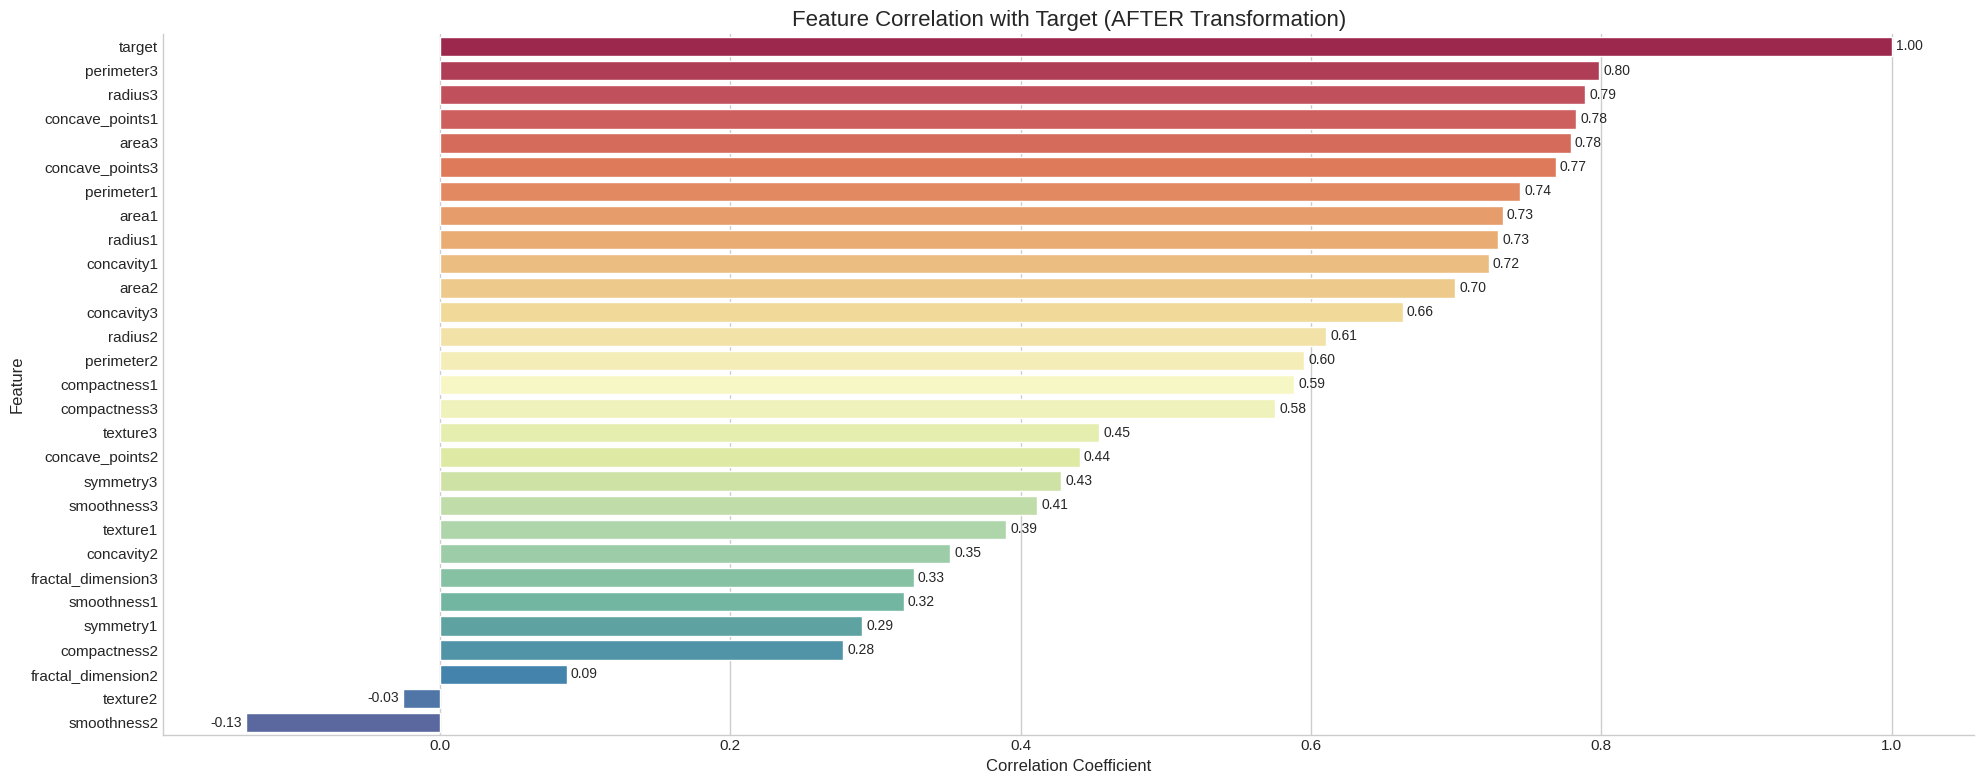

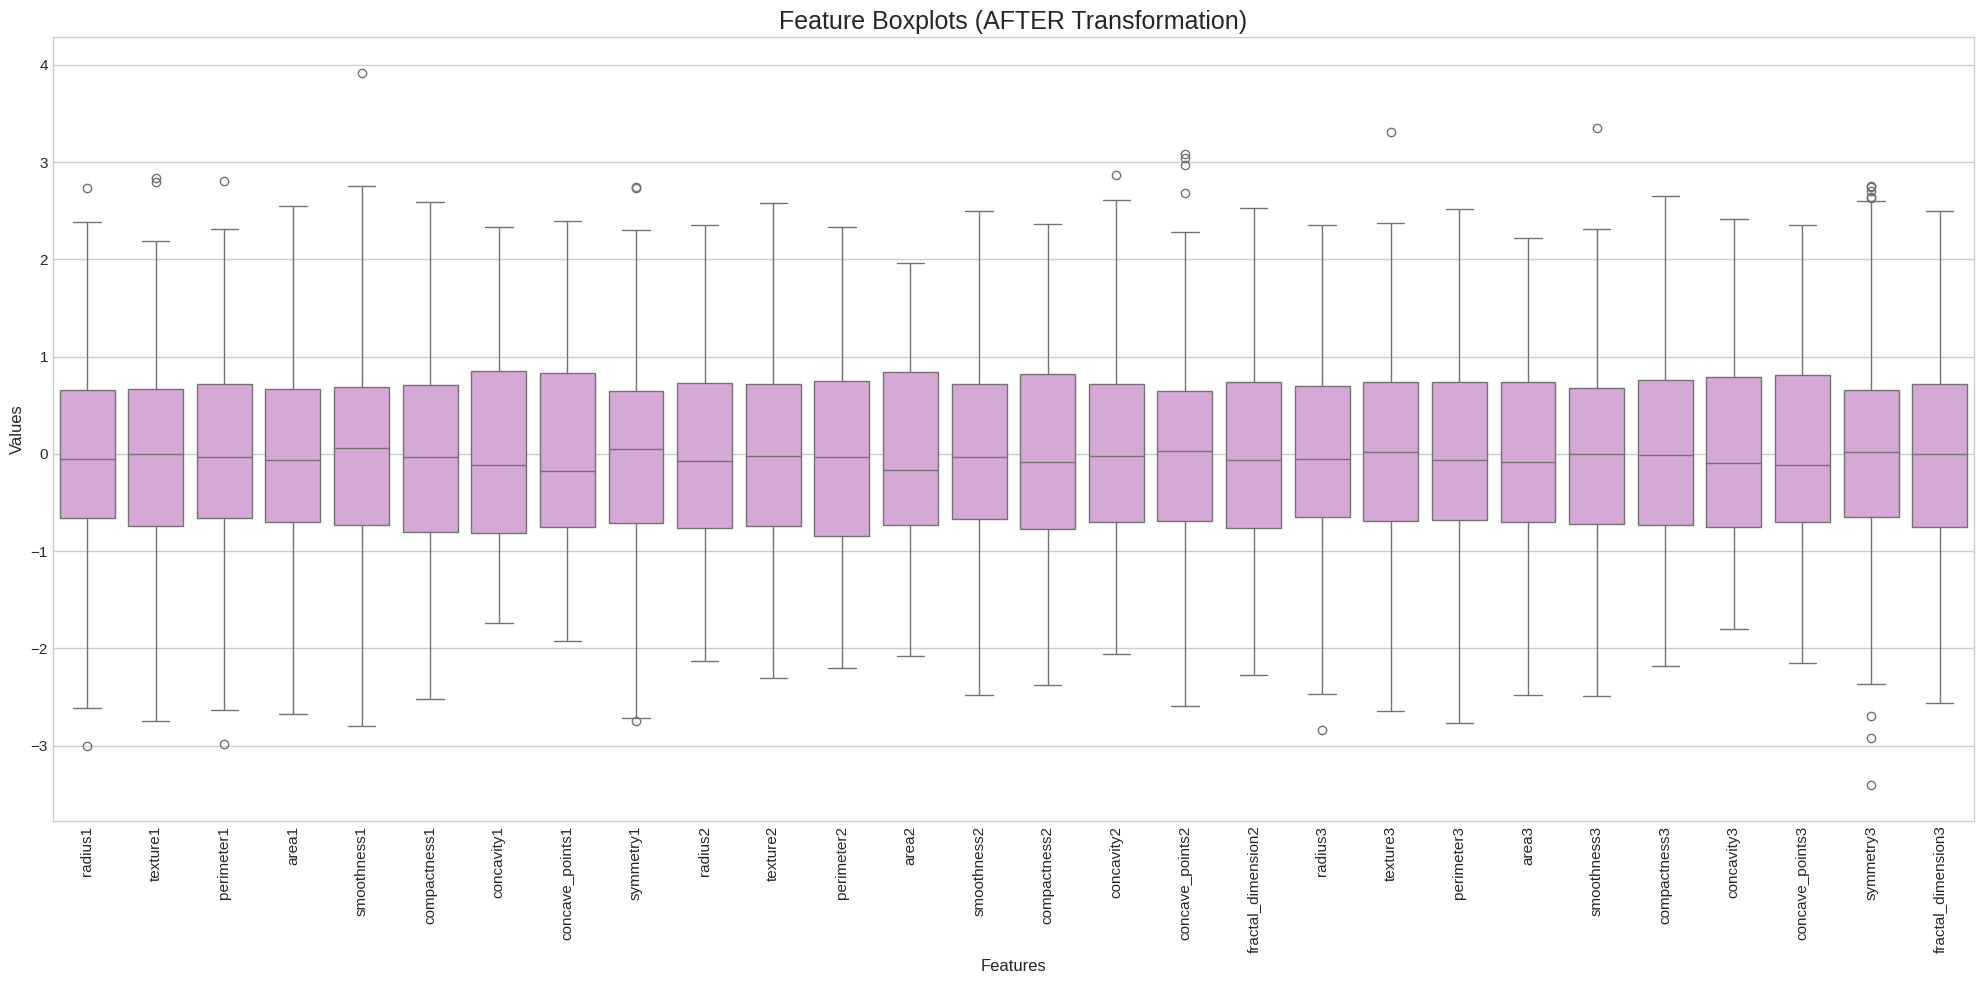

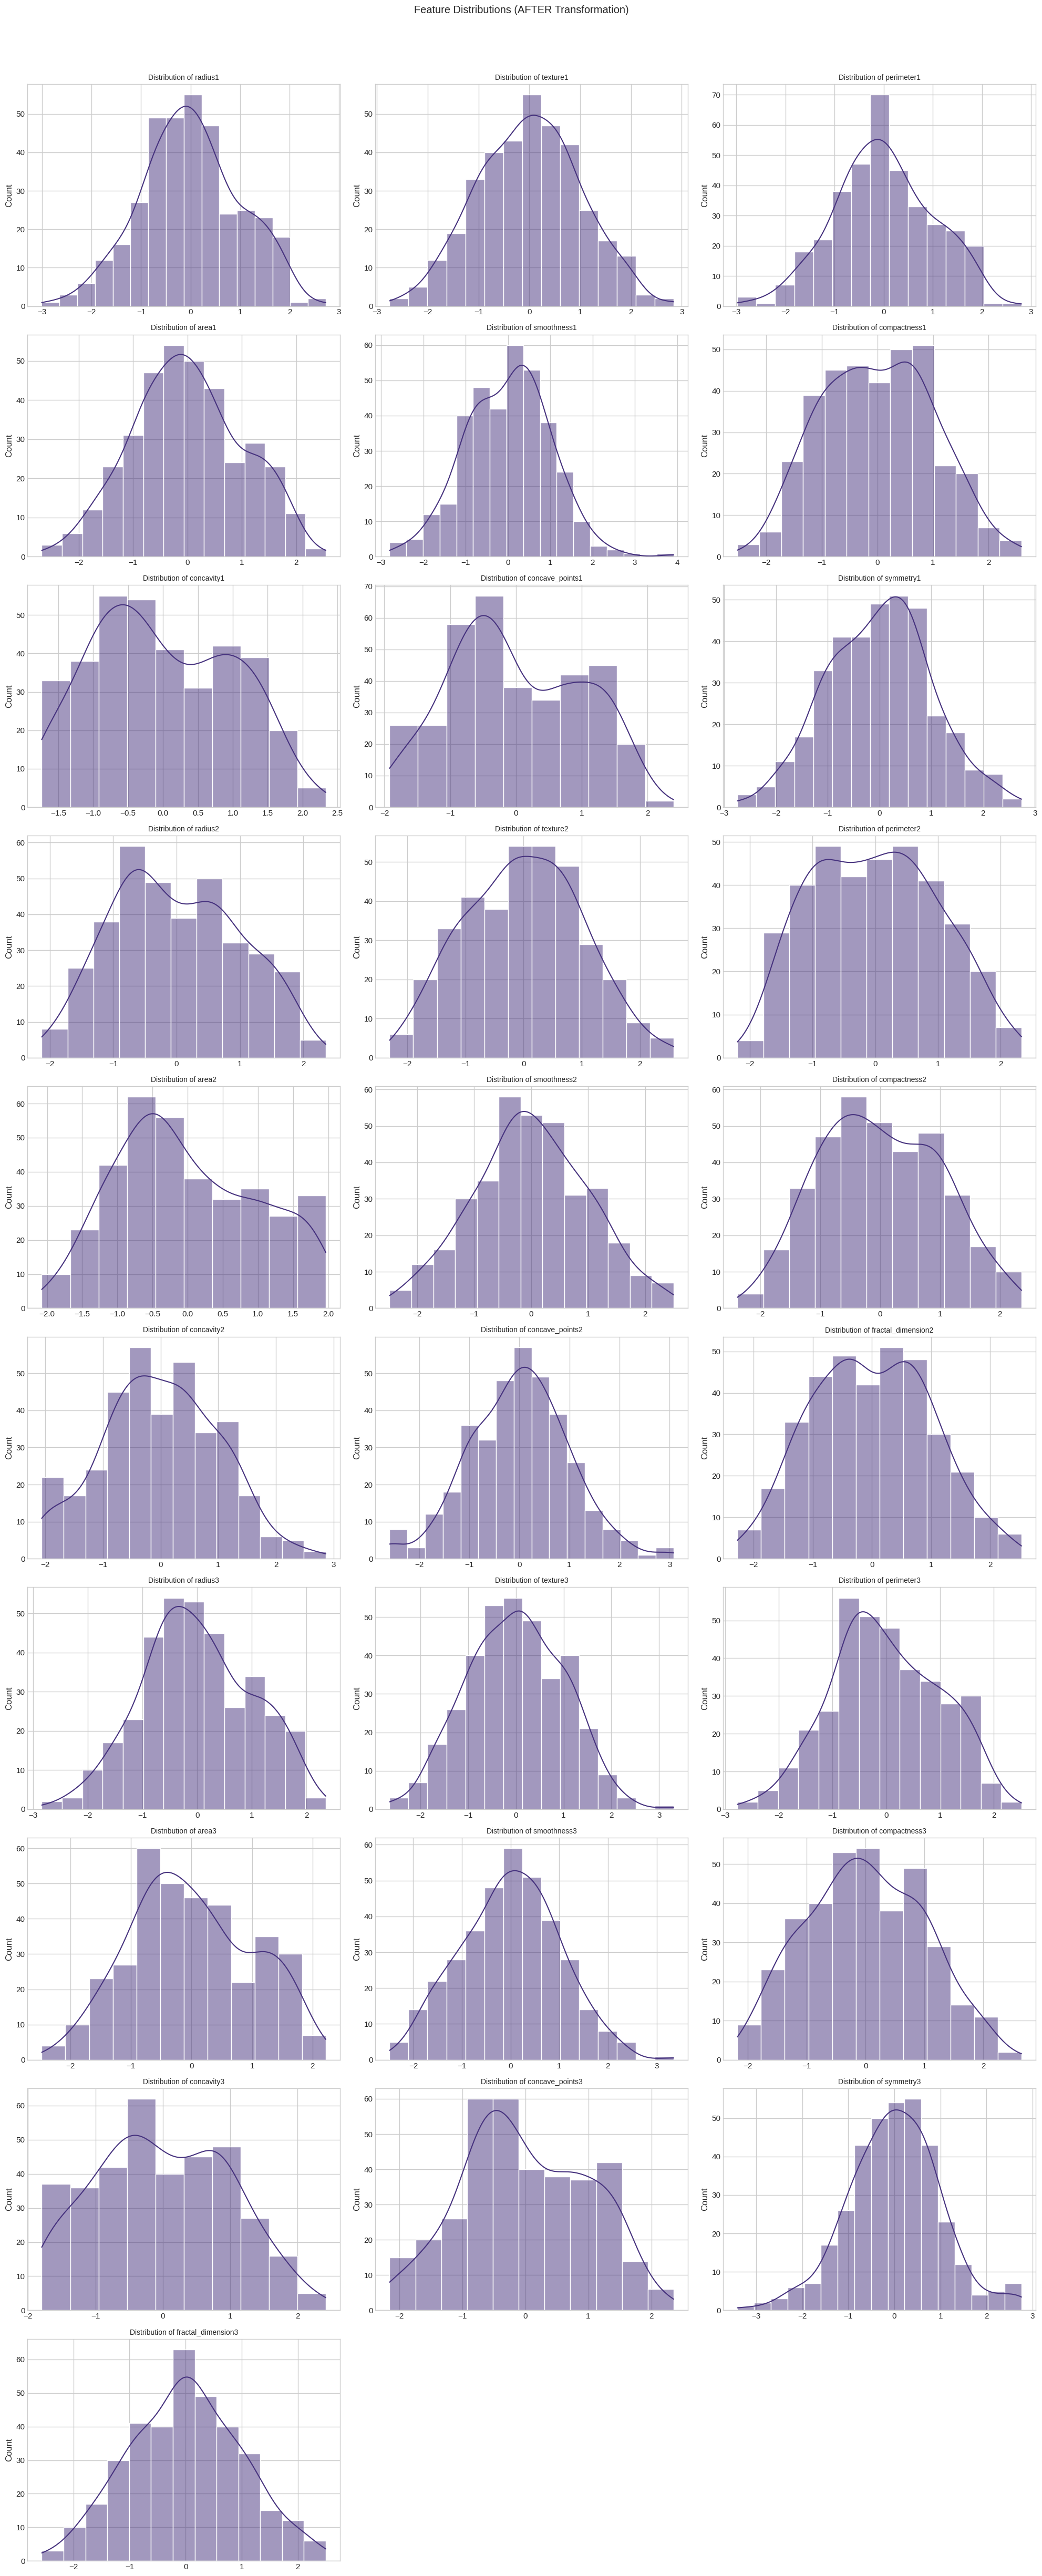

In [ ]:
# Visualize transformed data
plot_correlation_matrix(X_train, y_train, title_suffix='(AFTER Transformation)')
plot_boxplots(pd.DataFrame(X_train_preprocessed, columns=feature_names), title_suffix='(AFTER Transformation)')
plot_histograms(pd.DataFrame(X_train_preprocessed, columns=feature_names), title_suffix='(AFTER Transformation)')

In [ ]:
cmaps = ['Blues', 'Greens', 'Purples', 'Oranges']

In [ ]:
# Initialize base models
base_models = [
    DecisionTreeClassifier(random_state=42),
    LogisticRegression(random_state=42),
    KNeighborsClassifier(),
    GaussianNB()
]

base_model_names = [
    "Base Decision Tree",
    "Base Logistic Regression",
    "Base K-NN",
    "Base Naive Bayes"
]


=== EVALUATING BASE MODELS ===


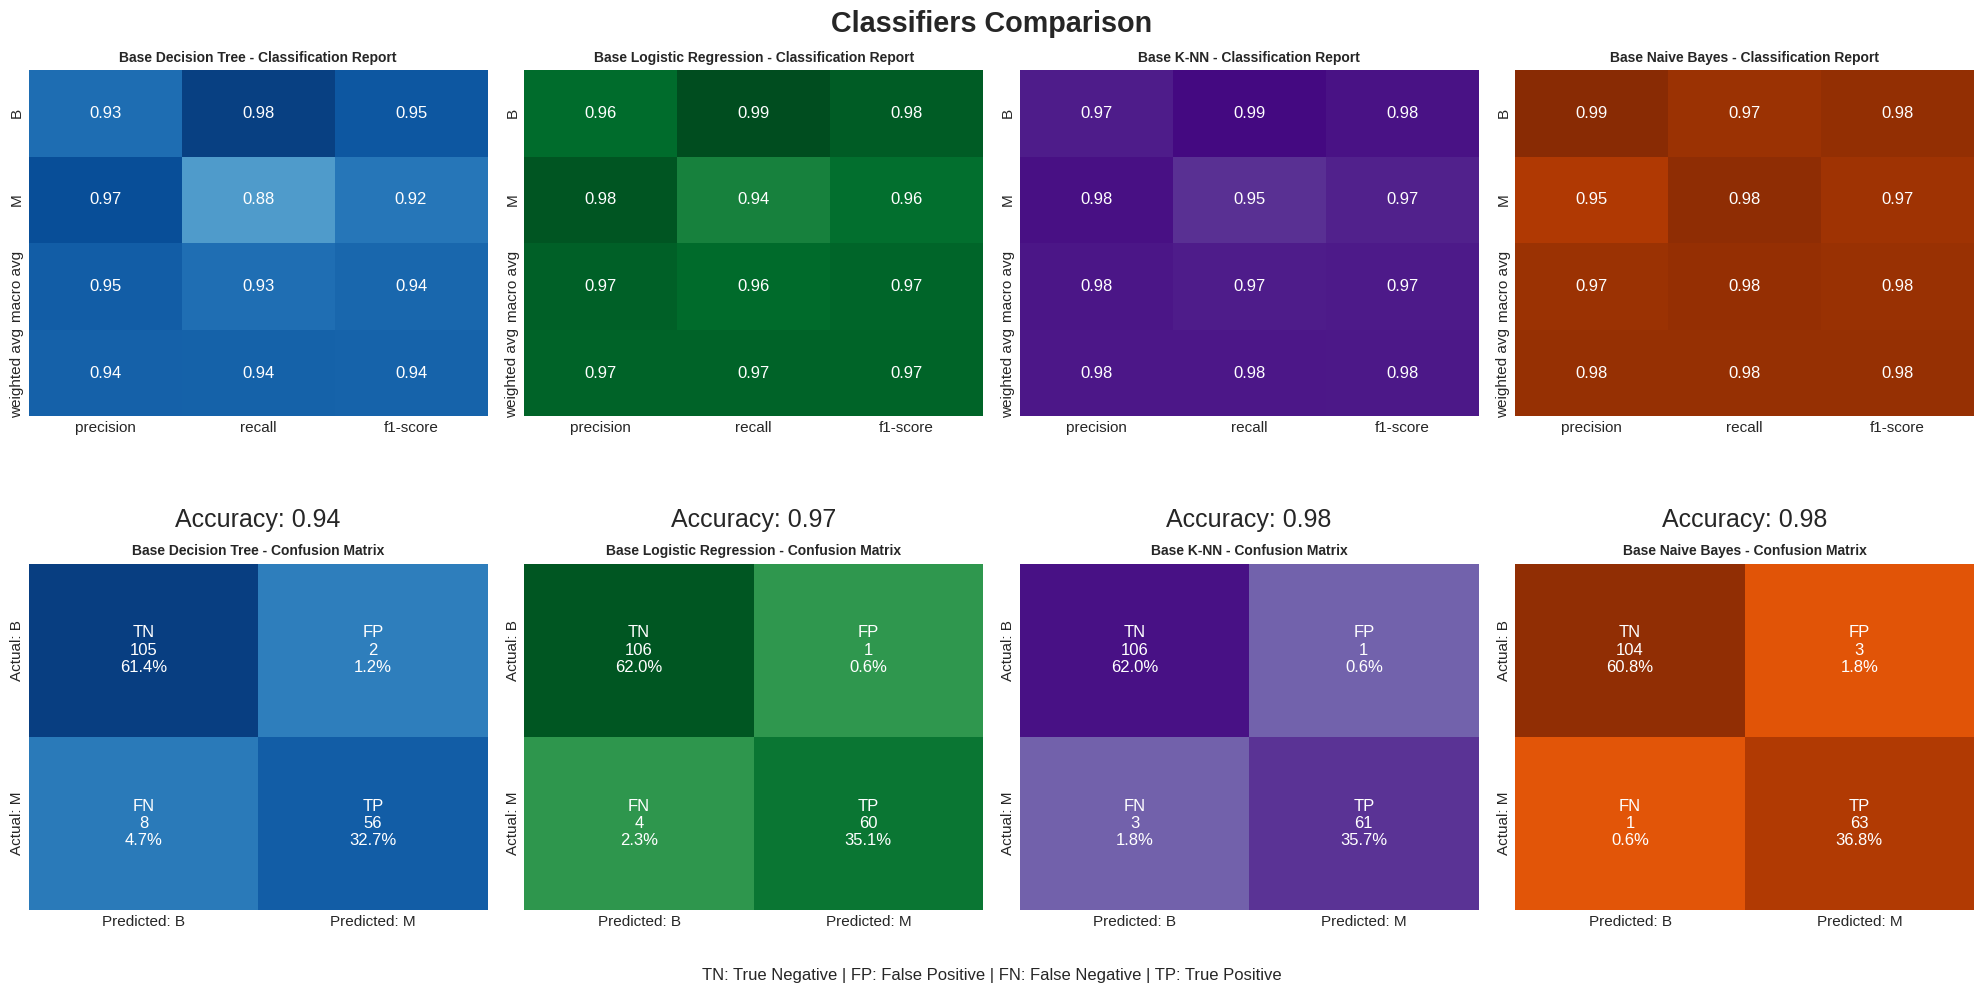

In [ ]:
# Compare base models using enhanced visualization
print("\n=== EVALUATING BASE MODELS ===")
compare_classifiers(
    base_models,
    base_model_names,
    X_train_preprocessed,
    X_test_preprocessed,
    y_train,
    y_test,
    cmaps
)


=== OPTIMIZING MODELS ===
Best Decision Tree params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15}
Best Logistic Regression params: {'C': np.float64(0.26828750938254387), 'penalty': 'l2', 'solver': 'liblinear'}
Best KNN params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best Naive Bayes params: {'var_smoothing': np.float64(1.0)}

=== EVALUATING OPTIMIZED MODELS ===


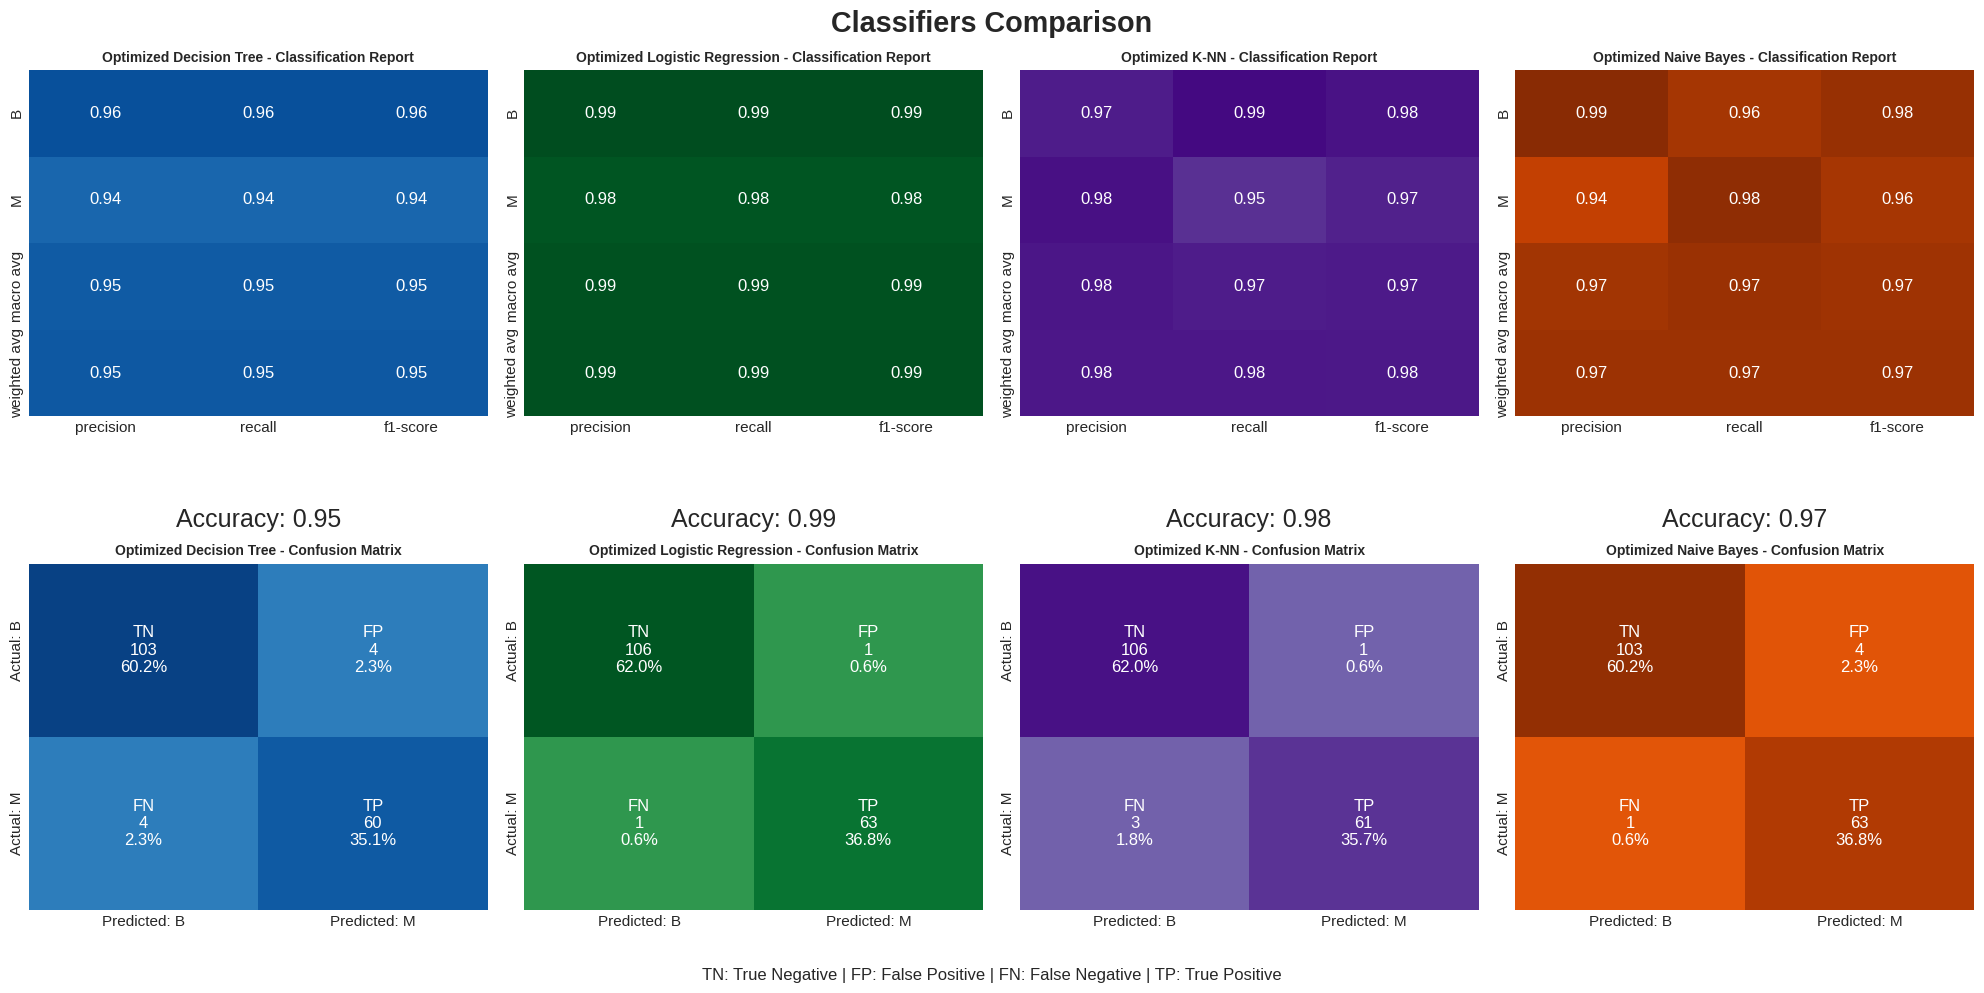

In [ ]:
# Optimize models
print("\n=== OPTIMIZING MODELS ===")
optimized_models = {
    "Optimized Decision Tree": optimize_decision_tree(X_train_preprocessed, y_train),
    "Optimized Logistic Regression": optimize_logistic_regression(X_train_preprocessed, y_train),
    "Optimized K-NN": optimize_knn(X_train_preprocessed, y_train),
    "Optimized Naive Bayes": optimize_naive_bayes(X_train_preprocessed, y_train)
}

# Compare optimized models using enhanced visualization
print("\n=== EVALUATING OPTIMIZED MODELS ===")
compare_classifiers(
    list(optimized_models.values()),
    list(optimized_models.keys()),
    X_train_preprocessed,
    X_test_preprocessed,
    y_train,
    y_test,
    cmaps
)

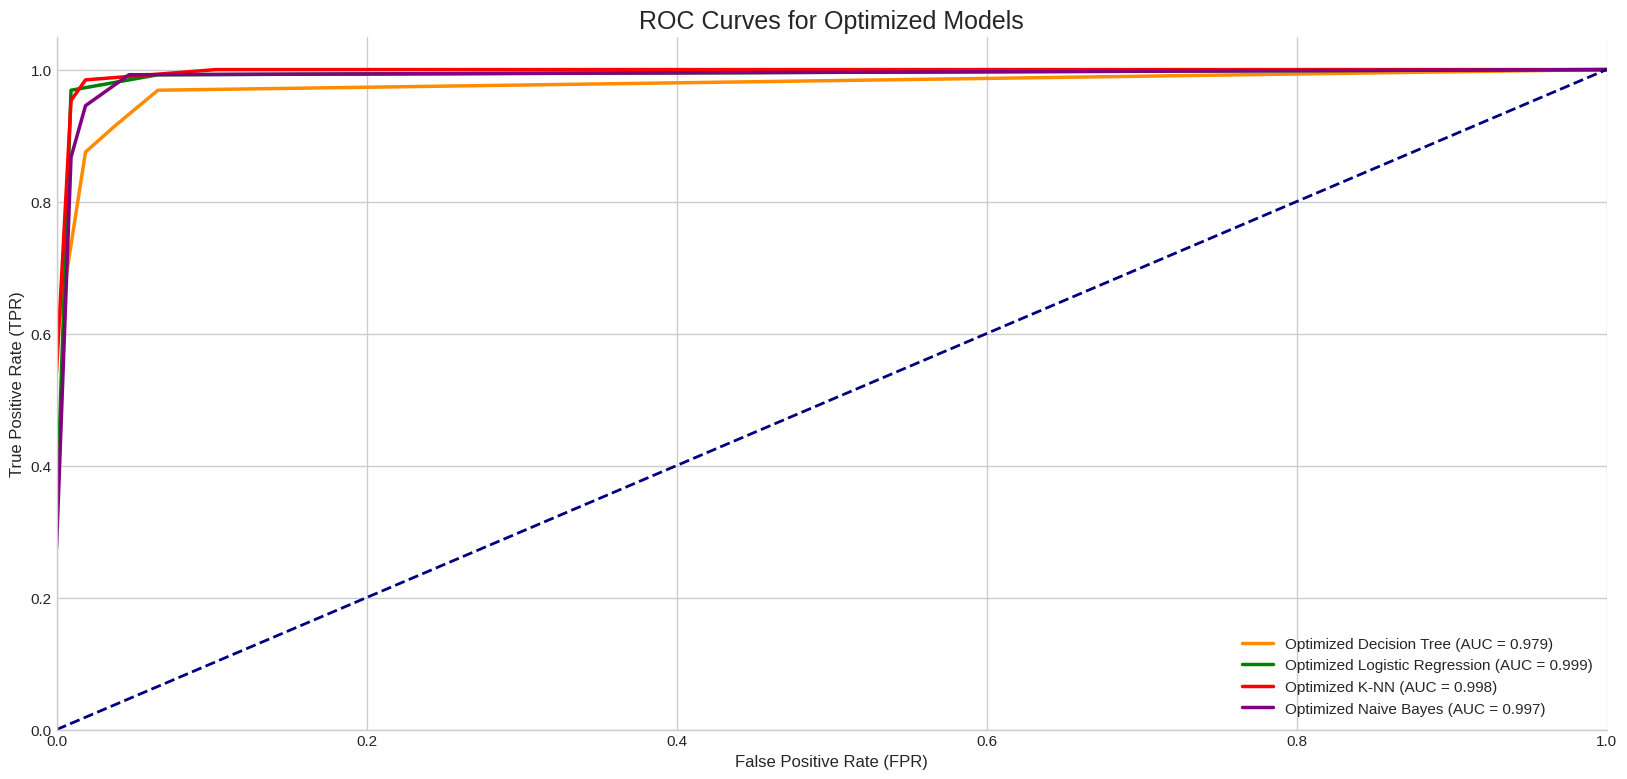

In [ ]:
# ROC Curve comparison
plot_roc_curve(optimized_models, X_test_preprocessed, y_test)

[INFO] Generating learning curves: Optimized Decision Tree


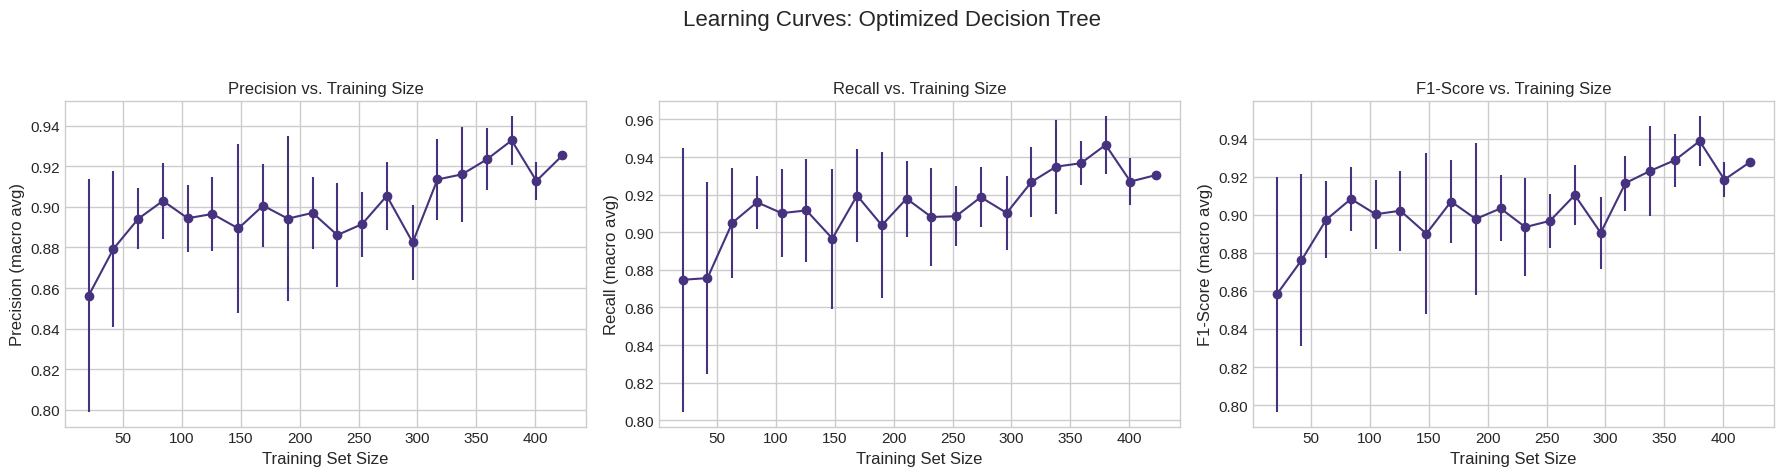

[INFO] Generating learning curves: Optimized Logistic Regression


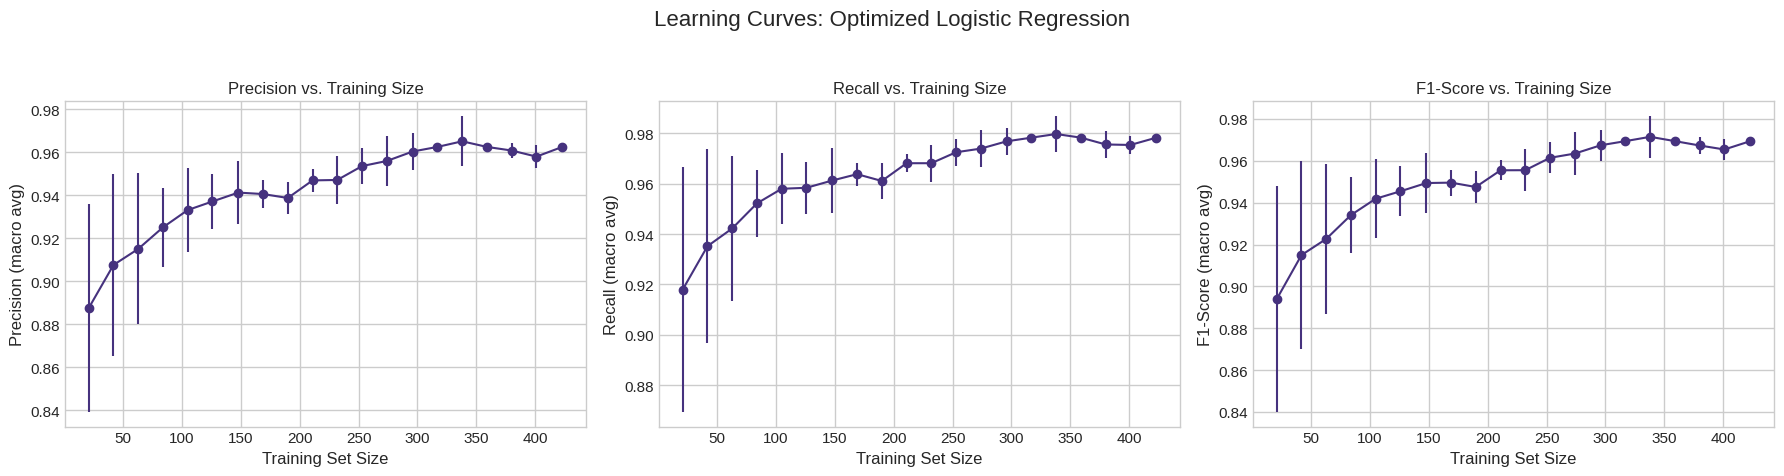

[INFO] Generating learning curves: Optimized K-NN


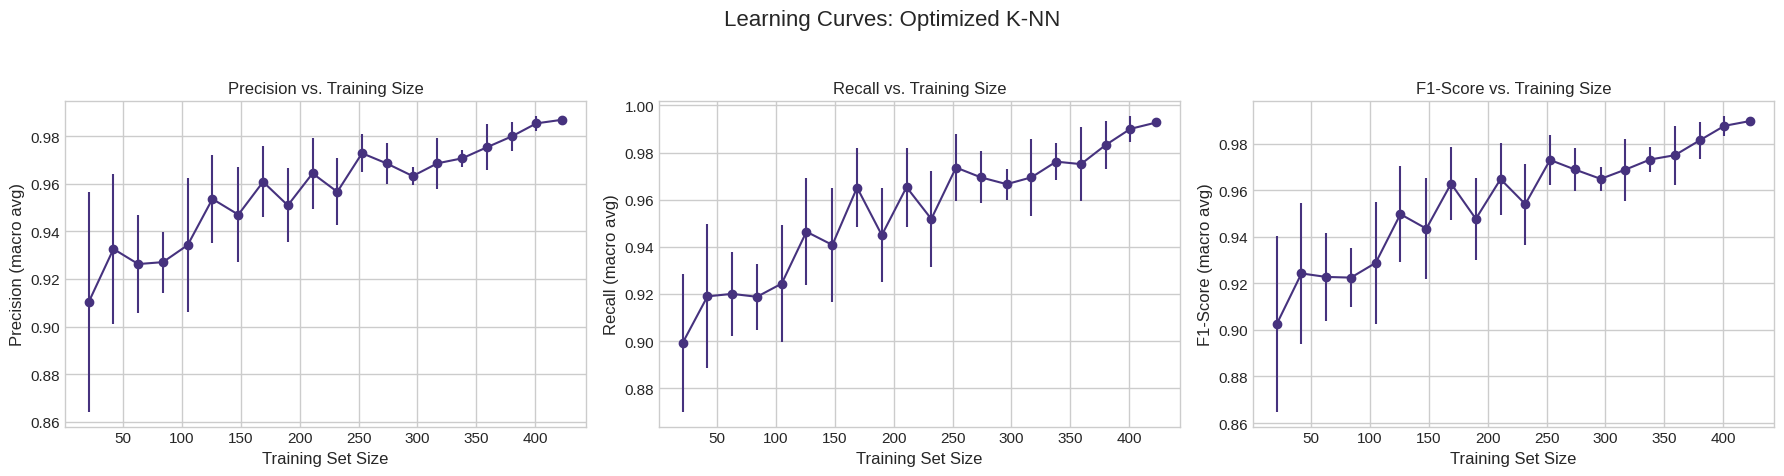

[INFO] Generating learning curves: Optimized Naive Bayes


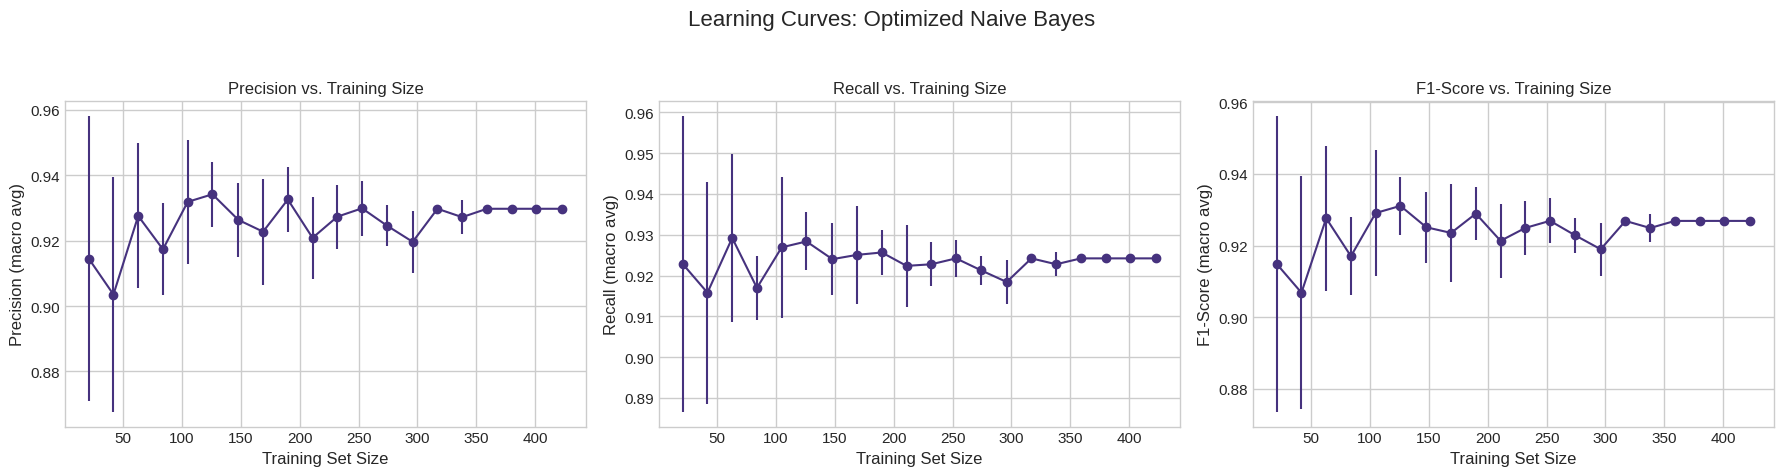

In [ ]:
# Learning curves
for name, model in optimized_models.items():
    X = np.concatenate([X_train_preprocessed, X_test_preprocessed], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    plot_learning_curves(model, name, X, y)